<a href="https://colab.research.google.com/github/MarsDana/fakenewsdetectionproject/blob/main/HAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[torch]
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from transformers import AutoTokenizer
from tqdm import tqdm

# Load and preprocess datasets
def load_datasets():
    # Load ISOT datasets
    fake_isot = pd.read_csv("/content/drive/MyDrive/datasets/ISOT/Fake.csv")
    real_isot = pd.read_csv("/content/drive/MyDrive/datasets/ISOT/True.csv")
    real_isot['label'], fake_isot['label'] = 1, 0

    # Load PolitiFact datasets
    fake_politifact = pd.read_csv("/content/drive/MyDrive/datasets/fakenewsnet/politifact_fake.csv")
    real_politifact = pd.read_csv("/content/drive/MyDrive/datasets/fakenewsnet/politifact_real.csv")
    fake_politifact['label'], real_politifact['label'] = 0, 1
    fake_politifact.rename(columns={'title': 'text'}, inplace=True)
    real_politifact.rename(columns={'title': 'text'}, inplace=True)

    # Load LIAR dataset
    liar = pd.read_csv("/content/drive/MyDrive/datasets/liar_dataset/test.tsv", sep="\t", header=None)
    liar.columns = [
        "id", "label", "statement", "subject", "speaker", "job", "state", "party",
        "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"
    ]
    liar['label'] = liar['label'].apply(lambda x: 1 if x in ["true", "mostly-true", "half-true"] else 0)
    liar = liar[["statement", "label"]].rename(columns={"statement": "text"})

    # Combine datasets
    combined_df = pd.concat([real_isot, fake_isot, real_politifact, fake_politifact, liar], ignore_index=True)
    return combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Prepare datasets for training
def prepare_datasets(df, test_size=0.2, reduce_frac=1/3):
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=42)
    train_df = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=reduce_frac, random_state=42))
    val_df = val_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=reduce_frac, random_state=42))
    return train_df, val_df

# Dataset class for HAN
class TextClassificationDataset(Dataset):
    def __init__(self, articles, labels, tokenizer, max_sentence_len, max_sentences):
        self.articles = articles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_sentence_len = max_sentence_len
        self.max_sentences = max_sentences

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        text = self.articles[idx]
        label = self.labels[idx]

        # Tokenize into sentences and then words
        sentences = text.split(". ")[:self.max_sentences]  # Limit to max_sentences
        tokenized_sentences = [
            self.tokenizer(sentence, padding="max_length", truncation=True, max_length=self.max_sentence_len)["input_ids"]
            for sentence in sentences
        ]

        # Pad to ensure uniform shape
        while len(tokenized_sentences) < self.max_sentences:
            tokenized_sentences.append([0] * self.max_sentence_len)

        return {
            "input_ids": torch.tensor(tokenized_sentences),
            "labels": torch.tensor(label)
        }

# HAN Model Definition
class HAN(nn.Module):
    def __init__(self, vocab_size, embed_dim, word_gru_hidden, sent_gru_hidden, num_classes):
        super(HAN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.word_gru = nn.GRU(embed_dim, word_gru_hidden, bidirectional=True, batch_first=True)
        self.word_attention = nn.Linear(2 * word_gru_hidden, 1)
        self.sent_gru = nn.GRU(2 * word_gru_hidden, sent_gru_hidden, bidirectional=True, batch_first=True)
        self.sent_attention = nn.Linear(2 * sent_gru_hidden, 1)
        self.fc = nn.Linear(2 * sent_gru_hidden, num_classes)

    def forward(self, x):
        batch_size, num_sentences, num_words = x.size()

        # Word-level encoding
        x = x.view(-1, num_words)  # Flatten sentences
        embeddings = self.embedding(x)
        word_output, _ = self.word_gru(embeddings)
        word_attention_weights = torch.softmax(self.word_attention(word_output), dim=1)
        sentence_embeddings = (word_output * word_attention_weights).sum(dim=1)

        # Sentence-level encoding
        sentence_embeddings = sentence_embeddings.view(batch_size, num_sentences, -1)
        sent_output, _ = self.sent_gru(sentence_embeddings)
        sent_attention_weights = torch.softmax(self.sent_attention(sent_output), dim=1)
        doc_embedding = (sent_output * sent_attention_weights).sum(dim=1)

        # Classification
        return self.fc(doc_embedding)

# Training and Evaluation Loops
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Initialize tracking variables
training_losses = []
val_losses = []
roc_aucs = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Training Loop
for epoch in range(5):
    # Train the model
    train_loss = train_model(model, train_loader, optimizer, criterion, device="cuda")
    training_losses.append(train_loss)

    # Evaluate on the validation set
    model.eval()
    val_loss = 0
    preds, targets, pred_probs = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to("cuda")
            labels = batch["labels"].to("cuda")

            outputs = model(input_ids)
            val_loss += criterion(outputs, labels).item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())  # Predicted labels
            targets.extend(labels.cpu().numpy())
            pred_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Positive class probabilities

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Calculate metrics
    accuracy = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, average="weighted")
    recall = recall_score(targets, preds, average="weighted")
    f1 = f1_score(targets, preds, average="weighted")
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(targets, pred_probs)
    roc_aucs.append(roc_auc)

# Print Final Results
print("Final Results:")
print(f"Train Loss: {training_losses[-1]:.4f}")
print(f"Validation Loss: {val_losses[-1]:.4f}")
print(f"Accuracy: {accuracies[-1]:.4f}")
print(f"Precision: {precisions[-1]:.4f}")
print(f"Recall: {recalls[-1]:.4f}")
print(f"F1-Score: {f1_scores[-1]:.4f}")
print(f"ROC-AUC: {roc_aucs[-1]:.4f}")


100%|██████████| 787/787 [00:30<00:00, 25.68it/s]


Final Results:
Train Loss: 0.0019
Validation Loss: 0.1187
Accuracy: 0.9790
Precision: 0.9791
Recall: 0.9790
F1-Score: 0.9790
ROC-AUC: 0.9984


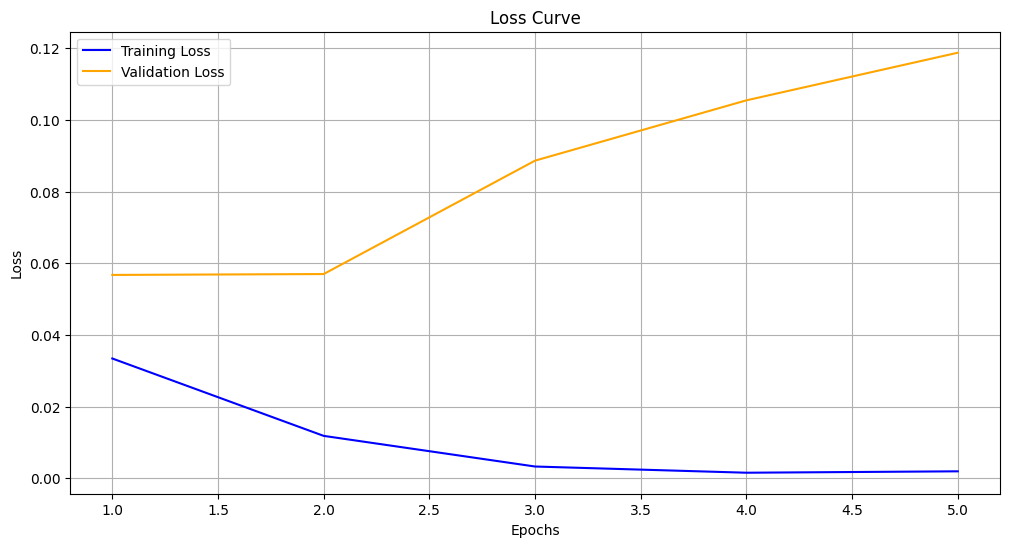

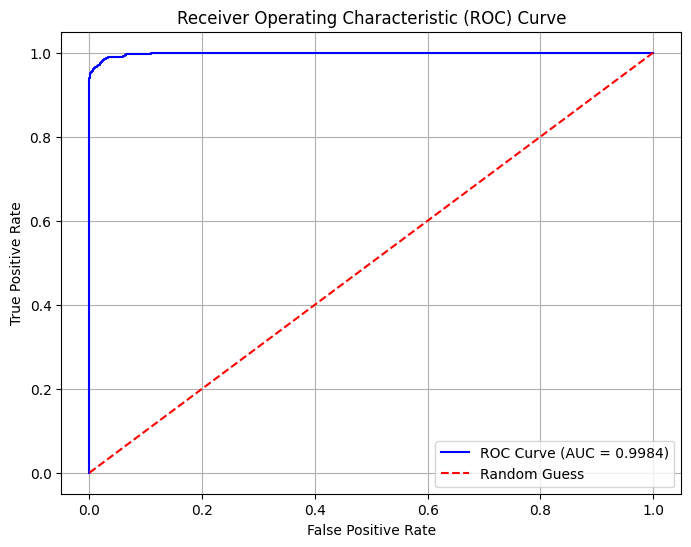

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


# Plot Loss Curve
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Plot ROC Curve for the Final Epoch
fpr, tpr, _ = roc_curve(targets, pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_aucs[-1]:.4f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()
